In [ ]:
%tensorflow_version 2.x
from tensorflow.keras.layers import Conv2DTranspose, BatchNormalization, LeakyReLU, Reshape, Dense, Flatten, Input, UpSampling2D, Concatenate, Conv2D
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

In [ ]:
input_shape = (224, 224, 3)

### Version 1: Flatten Encoder Output

In [ ]:
encoder_model = VGG16(include_top=False, weights=None, input_shape=input_shape)
feature_extractor = Model(encoder_model.layers[0].input, encoder_model.layers[-1].output)

input_layer = Input(shape=input_shape)
feature_extractor_out = feature_extractor(input_layer)
x = Flatten()(feature_extractor_out)

feature_extractor_out_shape = K.int_shape(feature_extractor_out)
flatten_layer_n = x.shape[1]

x = Dense(2048)(x)
latent_space = Dense(1024)(x)

encoder = Model(input_layer, latent_space, name='encoder')

In [ ]:
feature_extractor.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
model (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 2048)              51382272  
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
Total params: 68,195,136
Trainable params: 68,195,136
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Reconstruct VGG16
latent_space_input = Input(shape=(encoder.get_output_shape_at(-1)[1]))
x = Dense(2048)(latent_space_input)
x = Dense(flatten_layer_n)(x)
x = Reshape(feature_extractor_out_shape[1:])(x)

for _ in range(2):
    x = UpSampling2D()(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', activation='relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', activation='relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', activation='relu')(x)

x = UpSampling2D()(x)
x = Conv2DTranspose(256, (3, 3), padding='same', activation='relu')(x)
x = Conv2DTranspose(256, (3, 3), padding='same', activation='relu')(x)
x = Conv2DTranspose(256, (3, 3), padding='same', activation='relu')(x)

x = UpSampling2D()(x)
x = Conv2DTranspose(128, (3, 3), padding='same', activation='relu')(x)
x = Conv2DTranspose(128, (3, 3), padding='same', activation='relu')(x)

x = UpSampling2D()(x)
x = Conv2DTranspose(64, (3, 3), padding='same', activation='relu')(x)
x = Conv2DTranspose(64, (3, 3), padding='same', activation='relu')(x)

decoded_output = Conv2DTranspose(3, (3, 3), padding="same")(x)

decoder = Model(latent_space_input, decoded_output, name="decoder")

In [ ]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1024)]            0         
_________________________________________________________________
dense_2 (Dense)              (None, 2048)              2099200   
_________________________________________________________________
dense_3 (Dense)              (None, 25088)             51405312  
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 512)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 512)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 512)       2359808   
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 512)       2359

In [ ]:
autoencoder = Model(input_layer, decoder(encoder(input_layer)), name="autoencoder")

In [ ]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
encoder (Model)              (None, 1024)              68195136  
_________________________________________________________________
decoder (Model)              (None, 224, 224, 3)       70578499  
Total params: 138,773,635
Trainable params: 138,773,635
Non-trainable params: 0
_________________________________________________________________


### Version 2: Keep Encoder Conv Output

In [ ]:
encoder_model = VGG16(include_top=False, weights=None, input_shape=input_shape)
feature_extractor = Model(encoder_model.layers[0].input, encoder_model.layers[-1].output)
input_layer = Input(shape=input_shape)
latent_space = feature_extractor(input_layer)

encoder = Model(input_layer, latent_space, name='encoder')


In [ ]:
feature_extractor.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 416, 416, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 416, 416, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 416, 416, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 208, 208, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 208, 208, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 208, 208, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 104, 104, 128)     0     

In [ ]:
# Reconstruct VGG16
latent_space_input = Input(shape=(encoder.get_output_shape_at(-1)[1:]))

x = UpSampling2D()(latent_space_input)
x = Conv2DTranspose(512, (3, 3), padding='same', activation='relu')(x)
x = Conv2DTranspose(512, (3, 3), padding='same', activation='relu')(x)
x = Conv2DTranspose(512, (3, 3), padding='same', activation='relu')(x)

x = UpSampling2D()(x)
x = Conv2DTranspose(512, (3, 3), padding='same', activation='relu')(x)
x = Conv2DTranspose(512, (3, 3), padding='same', activation='relu')(x)
x = Conv2DTranspose(512, (3, 3), padding='same', activation='relu')(x)

x = UpSampling2D()(x)
x = Conv2DTranspose(256, (3, 3), padding='same', activation='relu')(x)
x = Conv2DTranspose(256, (3, 3), padding='same', activation='relu')(x)
x = Conv2DTranspose(256, (3, 3), padding='same', activation='relu')(x)

x = UpSampling2D()(x)
x = Conv2DTranspose(128, (3, 3), padding='same', activation='relu')(x)
x = Conv2DTranspose(128, (3, 3), padding='same', activation='relu')(x)

x = UpSampling2D()(x)
x = Conv2DTranspose(64, (3, 3), padding='same', activation='relu')(x)
x = Conv2DTranspose(64, (3, 3), padding='same', activation='relu')(x)

decoded_output = Conv2DTranspose(3, (3, 3), padding="same")(x)

decoder = Model(latent_space_input, decoded_output, name="decoder")

In [ ]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 13, 13, 512)]     0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 26, 26, 512)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 26, 26, 512)       2359808   
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 26, 26, 512)       2359808   
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 26, 26, 512)       2359808   
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 52, 52, 512)       0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 52, 52, 512)       2359

In [ ]:
autoencoder = Model(input_layer, decoder(encoder(input_layer)), name="autoencoder")

In [ ]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 416, 416, 3)]     0         
_________________________________________________________________
encoder (Model)              (None, 13, 13, 512)       14714688  
_________________________________________________________________
decoder (Model)              (None, 416, 416, 3)       17073987  
Total params: 31,788,675
Trainable params: 31,788,675
Non-trainable params: 0
_________________________________________________________________


### Version 3: Concatenated Encoder

In [ ]:
encoder_model_1 = VGG16(include_top=False, weights=None, input_shape=input_shape)
feature_extractor_1 = Model(encoder_model_1.layers[0].input, encoder_model_1.layers[-1].output)

input_layer_1 = Input(shape=input_shape)
latent_space_1 = feature_extractor_1(input_layer_1)

encoder_model_2 = VGG16(include_top=False, weights=None, input_shape=input_shape)
feature_extractor_2 = Model(encoder_model_2.layers[0].input, encoder_model_2.layers[-1].output)

input_layer_2 = Input(shape=input_shape)
latent_space_2 = feature_extractor_2(input_layer_1)

encoder_output = Concatenate()([latent_space_1, latent_space_2])

encoder = Model([input_layer_1, input_layer_2], encoder_output, name='encoder')


In [ ]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 416, 416, 3) 0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 13, 13, 512)  14714688    input_2[0][0]                    
__________________________________________________________________________________________________
model_1 (Model)                 (None, 13, 13, 512)  14714688    input_2[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 416, 416, 3) 0                                            
____________________________________________________________________________________________

In [ ]:
# Reconstruct VGG16
latent_space_input = Input(shape=(encoder.get_output_shape_at(-1)[1:]))

# x = Conv2D(512, (1, 1), padding='same', activation='relu')(latent_space_input)

x = UpSampling2D()(latent_space_input)
x = Conv2DTranspose(512, (3, 3), padding='same', activation='relu')(x)
x = Conv2DTranspose(512, (3, 3), padding='same', activation='relu')(x)
x = Conv2DTranspose(512, (3, 3), padding='same', activation='relu')(x)

x = UpSampling2D()(x)
x = Conv2DTranspose(512, (3, 3), padding='same', activation='relu')(x)
x = Conv2DTranspose(512, (3, 3), padding='same', activation='relu')(x)
x = Conv2DTranspose(512, (3, 3), padding='same', activation='relu')(x)

x = UpSampling2D()(x)
x = Conv2DTranspose(256, (3, 3), padding='same', activation='relu')(x)
x = Conv2DTranspose(256, (3, 3), padding='same', activation='relu')(x)
x = Conv2DTranspose(256, (3, 3), padding='same', activation='relu')(x)

x = UpSampling2D()(x)
x = Conv2DTranspose(128, (3, 3), padding='same', activation='relu')(x)
x = Conv2DTranspose(128, (3, 3), padding='same', activation='relu')(x)

x = UpSampling2D()(x)
x = Conv2DTranspose(64, (3, 3), padding='same', activation='relu')(x)
x = Conv2DTranspose(64, (3, 3), padding='same', activation='relu')(x)

decoded_output = Conv2DTranspose(3, (3, 3), padding="same")(x)

decoder = Model(latent_space_input, decoded_output, name="decoder")

In [ ]:
decoder.summary()

In [ ]:
autoencoder = Model([input_layer_1, input_layer_2], decoder(encoder([input_layer_1, input_layer_2])), name="autoencoder")

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_4:0


In [ ]:
autoencoder.summary()

Model: "autoencoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 416, 416, 3) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 416, 416, 3) 0                                            
__________________________________________________________________________________________________
encoder (Model)                 (None, 13, 13, 1024) 29429376    input_2[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
decoder (Model)                 (None, 416, 416, 3)  19433283    encoder[1][0]          

### Train

In [ ]:
autoencoder.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')

In [ ]:
import cv2
import numpy as np
import math

In [ ]:
def set_generator(batch_size, imgs, img_dims):
    pointer = 0
    while True:
        l_image = []
        for i in range(batch_size):
            if pointer == len(imgs):
                pointer = 0
            l_image.append('img_align_celeba/' + imgs[pointer])
            pointer += 1
        X, y = generate_Xy(l_image, img_dims)
        yield (X, y)

In [ ]:
def set_loader(batch_size, imgs, img_dims, pointer=0):
    l_image = []
    for i in range(batch_size):
        l_image.append('img_align_celeba/' + imgs[pointer])
        pointer += 1
    X, y = generate_Xy(l_image, img_dims)
    return X, y, pointer

In [ ]:
def generate_Xy(l_image, img_dims):
    X, y = [], []
    for img_d in l_image:
        coloured = cv2.resize(cv2.imread(img_d), img_dims[:2])
        gray_coloured = cv2.cvtColor(cv2.cvtColor(coloured, cv2.COLOR_BGR2GRAY), cv2.COLOR_GRAY2BGR)
        X.append([gray_coloured / 255, gray_coloured / 255])
        y.append(coloured / 255)
    return np.asarray(X, dtype=np.float32), np.asarray(y, dtype=np.float32)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
!unzip "<path to img_align_celeba.zip>" -d /content/

In [ ]:
import os
import random

img_dir = os.listdir('img_align_celeba')

random.Random(2).shuffle(img_dir)

print(len(img_dir))

val_portion = math.ceil(len(img_dir) * 0.1)

val_img_dir = img_dir[-val_portion:]
img_dir = img_dir[:-val_portion]

print(len(val_img_dir), len(img_dir))

202599
20260 182339


In [ ]:
coloured = cv2.resize(cv2.imread('img_align_celeba/' + img_dir[1000]), (224, 224))
gray_coloured = cv2.cvtColor(cv2.cvtColor(coloured, cv2.COLOR_BGR2GRAY), cv2.COLOR_GRAY2BGR)

vis = np.concatenate((gray_coloured, coloured), axis=1)
for _ in range(2):
    cv2_imshow(vis)

In [ ]:
BATCH_SIZE = 16
EPOCHS = 1
train_loss_trace = []
val_loss_trace = []

In [ ]:
for e in range(EPOCHS):
    pointer = 0
    train_losses = []
    val_losses = []
    
    step_size = math.ceil(len(img_dir)/BATCH_SIZE)
    val_step_size = math.ceil(len(val_img_dir)/BATCH_SIZE)
    
    print('EPOCH - {} of {}:'.format(e + 1, EPOCHS))
    
    for step in range(step_size):
        if step == step_size - 1:
            final_batch = BATCH_SIZE if len(img_dir) % BATCH_SIZE == 0 else len(img_dir) % BATCH_SIZE
            X, y, _ = set_loader(final_batch, img_dir, input_shape, pointer)
        else:
            X, y, pointer = set_loader(BATCH_SIZE, img_dir, input_shape, pointer)
        # print(X[:,0,:,:].shape)
        # train_loss = autoencoder.train_on_batch(x=X, y=y)
        train_loss = autoencoder.train_on_batch(x=[X[:,0,:,:], X[:,1,:,:]], y=y)
        train_losses.append(train_loss)
        
        print('\t- Step {} of {} train_loss: {}\t avg. train_loss: {}'.format(step, step_size, train_loss, np.mean(np.array(train_losses))))
        
        if step % 50 == 0:
            print("Testing...\n")
            coloured = cv2.resize(cv2.imread('img_align_celeba/' + img_dir[2222]), (input_shape[0], input_shape[1]))
            gray_coloured = cv2.cvtColor(cv2.cvtColor(coloured, cv2.COLOR_BGR2GRAY), cv2.COLOR_GRAY2BGR)
            test_image = gray_coloured.astype(np.float32) / 255
            # output = autoencoder.predict(np.reshape(test_image, (1, input_shape[0], input_shape[1], 3))) * 255
            output = autoencoder.predict([np.reshape(test_image, (1, input_shape[0], input_shape[1], 3)), np.reshape(test_image, (1, input_shape[0], input_shape[1], 3))]) * 255
            test_result = np.concatenate((gray_coloured, coloured, np.reshape(output, input_shape)), axis=1)
            
            cv2_imshow(cv2.resize(test_result, (672, 224)))
    
    print()
    print('Calculating val_loss...')
    pointer = 0
    for step in range(val_step_size):
        if step == val_step_size - 1:
            final_batch = BATCH_SIZE if len(val_img_dir) % BATCH_SIZE == 0 else len(val_img_dir) % BATCH_SIZE
            X_val, y_val, _ = set_loader(final_batch, val_img_dir, input_shape, pointer)
        else:
            X_val, y_val, pointer = set_loader(BATCH_SIZE, val_img_dir, input_shape, pointer)
        # val_loss = autoencoder.test_on_batch(x=X_val, y=y_val)
        val_loss = autoencoder.test_on_batch(x=[X_val[:,0,:,:], X_val[:,1,:,:]], y=y_val)
        val_losses.append(val_loss)

        print('\t- Step {} of {} val_loss: {}'.format(step, val_step_size, val_loss))

    print()

    train_loss_trace.append(np.mean(train_losses))
    val_loss_trace.append(np.mean(val_losses))

    print('\ntrain_loss: {}'.format(np.mean(train_losses)))
    print('val_loss: {}'.format(np.mean(val_losses)))
    print('- - - - - - - - - -\n')
        

In [ ]:
autoencoder.save('<path to weights.h5>')

In [ ]:
def colourize(i_dir, autoencoder, input_shape):
    # coloured = cv2.resize(cv2.imread('img_align_celeba/' + val_img_dir[93]), (224, 224))
    # coloured = cv2.resize(cv2.imread('black-and-white-portrait-tips-3107.jpg'), (224, 224))
    coloured = cv2.resize(cv2.imread(i_dir), (input_shape[0], input_shape[1]))

    gray_coloured = cv2.cvtColor(cv2.cvtColor(coloured, cv2.COLOR_BGR2GRAY), cv2.COLOR_GRAY2BGR)
    test_image = gray_coloured.astype(np.float32) / 255
    # output = autoencoder.predict(np.reshape(test_image, (1, input_shape[0], input_shape[1], 3))) * 255
    output = autoencoder.predict([np.reshape(test_image, (1, input_shape[0], input_shape[1], 3)), np.reshape(test_image, (1, input_shape[0], input_shape[1], 3))]) * 255

    o = np.reshape(output, input_shape)
    blended = cv2.addWeighted(gray_coloured.astype(np.float32),0.5, o, 0.7, 0)

    hsv = cv2.cvtColor(blended, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    # h += value # 4
    s += 0.1 # 5
    # v += value # 6
    final_hsv = cv2.merge((h, s, v))
    enhanced = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

    kernel = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]])
    enhanced = cv2.filter2D(enhanced, -1, kernel)

    font = cv2.FONT_HERSHEY_SIMPLEX

    cv2.rectangle(gray_coloured, (0,0),(100,20),(0,0,0), cv2.FILLED)
    cv2.putText(gray_coloured, 'Gray Image', (3, 15), font, 0.5, (255,255,255), 1, cv2.LINE_AA)

    cv2.rectangle(coloured, (0,0),(90,20),(0,0,0), cv2.FILLED)
    cv2.putText(coloured, 'Ori. Image', (3, 15), font, 0.5, (255,255,255), 1, cv2.LINE_AA)

    output = np.reshape(output, input_shape)
    cv2.rectangle(output, (0,0),(100,20),(0,0,0),cv2.FILLED)
    cv2.putText(output, 'Net. Output', (3, 15), font, 0.5, (255,255,255), 1, cv2.LINE_AA)

    cv2.rectangle(blended, (0,0),(70,20),(0,0,0),cv2.FILLED)
    cv2.putText(blended, 'Blended', (3, 15), font, 0.5, (255,255,255), 1, cv2.LINE_AA)

    cv2.rectangle(enhanced, (0,0),(82,20),(0,0,0),cv2.FILLED)
    cv2.putText(enhanced, 'Enhanced', (3, 15), font, 0.5, (255,255,255), 1, cv2.LINE_AA)
    
    test_result = np.concatenate((coloured, gray_coloured, output, blended, enhanced), axis=1)
    cv2_imshow(cv2.resize(test_result, (1120,224)))

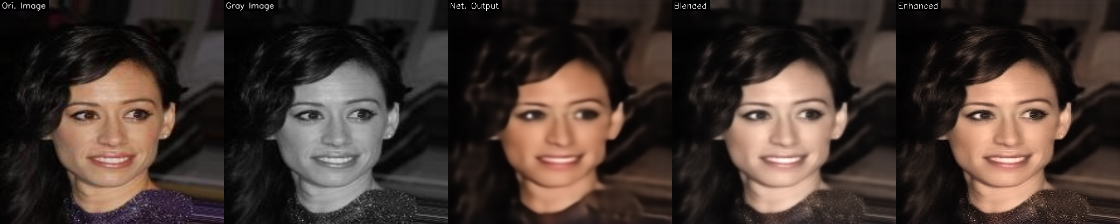

In [ ]:
for i_dir in random.sample(val_img_dir, 1):
    colourize('img_align_celeba/' + i_dir, autoencoder, input_shape)

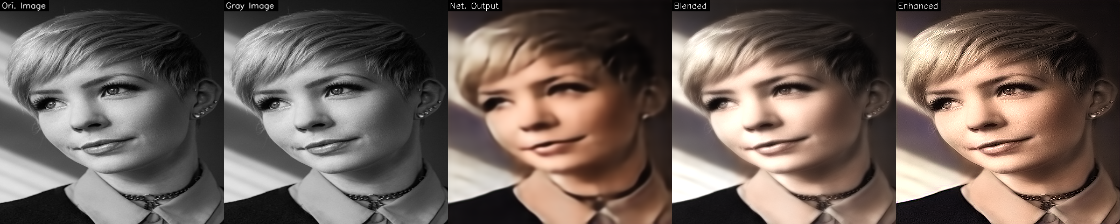

In [ ]:
colourize('<path to image>', autoencoder, input_shape)

In [ ]:
print("\n".join([str(x) for x in train_losses]))